In [1]:
import pandas as pd
import numpy as np
from twarc import Twarc
import constants as cnst
from newspaper import Article, ArticleException
from tqdm import tqdm
import string
import matplotlib.pylab as plt
import requests

In [2]:
primary = pd.read_csv('./retweet_July_13_20_22_main.csv', na_values=-1)
secondary = pd.read_csv('./retweet_July_13_20_13_secondary.csv', na_values=-1)
actual = pd.read_csv("./Organic_extended_finalv2.csv", na_values=-1,index_col=0, sep="|")
t = Twarc(cnst.consumer_key, cnst.consumer_secret,cnst.access_token, cnst.access_token_secret)

Identify unpopulated columns

In [3]:
columns = {str(i) for i in range(1,101)}
unpop_primary = set()
unpop_secondary = set()
for col in columns:
    if (primary[col].isna()).all():
        unpop_primary.add(col)
    if (secondary[col].isna()).all():
        unpop_secondary.add(col)
# print(unpop_primary)
# print(unpop_secondary)
unpop_union = unpop_primary |unpop_secondary
pop_cols = columns.difference(unpop_union)

Removing unpopulated columns

In [4]:
primary = primary[set(primary.columns).difference(unpop_union)]
print(primary.columns)
secondary = secondary[set(secondary.columns).difference(unpop_union)]
print(secondary.columns)

Index(['tweet_id', '12', '9', '5', '4', '28', '29', '23', '14', '6', '15',
       '11', '1', '3', '2', 'created_time', 'count', '10', '18', '16', '25',
       '20', '24', '13', 'next_update', '8', '26', '27', '7', '19', '22', '21',
       '17'],
      dtype='object')
Index(['tweet_id', '12', '9', '5', '4', '28', '29', '23', '14', '6', '15',
       '11', '1', '3', '2', 'created_time', 'count', '10', '18', '16', '25',
       '20', '24', '13', 'next_update', '8', '26', '27', '7', '19', '22', '21',
       '17'],
      dtype='object')


## Stats 1 :  Tweets per day

In [5]:
primary_stats = {}
secondary_stats = {}
for col in pop_cols:
    if col in primary:
        primary_stats[int(col)] = len(primary.loc[primary[col].notna()])
        secondary_stats[int(col)] = len(secondary.loc[secondary[col].notna()])

[(1, 39662), (2, 38679), (3, 37495), (4, 35859), (5, 34089), (6, 32409), (7, 30831), (8, 29437), (9, 28524), (10, 27463), (11, 25992), (12, 24306), (13, 22653), (14, 21009), (15, 19628), (16, 18672), (17, 17514), (18, 15843), (19, 14102), (20, 12476), (21, 10820), (22, 9398), (23, 8406), (24, 7175), (25, 5441), (26, 3695), (27, 2002), (28, 769), (29, 102)]
[(1, 37795), (2, 35686), (3, 33644), (4, 31294), (5, 29094), (6, 27196), (7, 25034), (8, 23021), (9, 21472), (10, 19997), (11, 18361), (12, 16789), (13, 15365), (14, 13809), (15, 12428), (16, 11321), (17, 10054), (18, 8817), (19, 7735), (20, 6800), (21, 5858), (22, 5224), (23, 4702), (24, 4032), (25, 2999), (26, 2004), (27, 1089), (28, 264), (29, 1)]


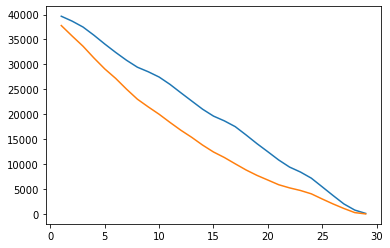

In [6]:
for stat_list in (primary_stats,secondary_stats):
    print(sorted(stat_list.items()))
    lists = sorted(stat_list.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y)
plt.show()

## Removing columns

### Setting column counts

In [7]:
column_count = 7

Weeds out columns that are not populated at all, and removes rows that are not above the defined threshold of column count

In [8]:
valid_columns = ["tweet_id","created_time","count"]+[str(i) for i in range(1, column_count)]
primary = primary.loc[primary['count'] >= column_count, valid_columns]
secondary = secondary.loc[secondary['count'] >= column_count, valid_columns]

Dropping rows with na

In [9]:
primary = primary.dropna()
secondary = secondary.dropna()

## Stats 2 : Difference

In [10]:
intersec_ids = set(secondary['tweet_id']).intersection(set(primary['tweet_id']))
diff_pri = set(primary['tweet_id']).difference(set(secondary['tweet_id']))
diff_sec = set(secondary['tweet_id']).difference(set(primary['tweet_id']))
len(intersec_ids),len(diff_pri),len(diff_sec)

(25693, 6716, 292)

In [11]:
captured_tweets = set(actual.tweet_id)
not_captured_intersection = intersec_ids.difference(captured_tweets)
not_captured_diff_pri = diff_pri.difference(captured_tweets)
not_captured_diff_sec = diff_sec.difference(captured_tweets)
len(captured_tweets), len(not_captured_intersection), len(not_captured_diff_pri), len(not_captured_diff_sec)

(12341, 16838, 3461, 61)

In [12]:
df = primary.loc[primary['tweet_id'].isin(not_captured_intersection)].copy()
df = df.append(primary.loc[primary['tweet_id'].isin(not_captured_diff_pri)])
df = df.append(secondary.loc[secondary['tweet_id'].isin(not_captured_diff_sec)])

In [13]:
df = df.reset_index().drop('index', axis=1)
len(df)

20360

In [14]:
df['user_id'] = np.nan
df['screen_name'] = np.nan
df['url'] = np.nan
df['follower_count'] = np.nan
df['title'] = np.nan
df['content'] = np.nan
df['expanded_url'] = np.nan


In [15]:
not_found = list()
for tweet in tqdm(t.hydrate(list(df['tweet_id'])),total=len(df['tweet_id'])) :   
    df.loc[(df.tweet_id == tweet["id"]), "user_id"] = tweet["user"]["id"]
    df.loc[(df.tweet_id == tweet["id"]), "screen_name"] = tweet["user"]["name"]
    df.loc[(df.tweet_id == tweet["id"]), "follower_count"] = tweet["user"]["followers_count"]
    try:
        df.loc[(df.tweet_id == tweet["id"]), "url"] = tweet["entities"]["urls"][0]["expanded_url"]
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20360/20360 [02:45<00:00, 122.80it/s]


In [16]:
df.to_csv("./partial4.csv")

In [17]:
df = df.dropna(subset=['url'])
len(df)

18949

In [18]:
http = requests.Session()
for idx, row in tqdm(df.iterrows(), total=len(df)):
#     row = uci.loc[idx]  
    
    try:
        exp_url = http.get(row.url, timeout=15).url
        df.loc[df['url']==row.url,'expanded_url'] = exp_url
        article = Article(exp_url)
        article.download()
        article.parse()
        df.loc[df.url == row.url, 'title']=article.title.replace("|", " ")
        df.loc[df.url == row.url, 'content']=article.text.replace("|", " ")
        if idx%400 == 0 and idx != 0:
            df[:idx].to_csv("./Organic_extended_v2_{}.csv".format(idx), sep="|")
#             break
    except Exception as e:
        pass
#         print(str(e))
#         print(row['url'])
df.to_csv("./Organic_extended_v2.csv", sep="|")        
# print(not_parsed)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18949/18949 [10:47:34<00:00,  2.05s/it]


In [19]:
actual = actual.append(df, ignore_index=True)

In [20]:
len(actual)

31290

In [21]:
actual.to_csv("Organic_extended_final.csv", sep="|")